In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
# model
from torch import nn
# datasets/dataloader operations
import torchvision.datasets as datasets # for dataloader
import torchvision.transforms as transforms # for dataloader
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:
# Choose GPU - mps because can be exported
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


### Load datasets

In [3]:
# Fashion DS
training_data_fashion = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data_fashion = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# Digits DS
training_data_digits = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data_digits = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 18358019.43it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 303394.29it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5488513.23it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5285747.12it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 86495152.08it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 104427322.26it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26146246.60it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6894871.07it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Define Neural Network architecture

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



# Laboratory begins here

Following cells serve different purpose:
1. Training loop according to defined hyperparameters
2. Laboratory - set different sets of parameters to perform grid search for best set of parameters
3. Evaluation/Saving stuff

## Training loop

### Helping functions

In [5]:
def train(dataloader, model, loss_fn, optimizer, device, verbose=True, debug=False):
    size = len(dataloader.dataset)
    batches_size = len(dataloader)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.squeeze(dim=1), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        verbose_period = np.floor(batches_size/10)
        if verbose and ((batch+1) % verbose_period == 0.0):
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"TRAIN: Batch {batch+1}, Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [6]:
def test(dataloader, model, loss_fn, device, verbose=True, debug=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            if debug:
                print(f"DEBUG: X.size(): {X.size()}, y.size(): {y.size()}\n"
                      f"DEBUG: pred.size(): {pred.size()}, y.size(): {y.size()}")
            test_loss += loss_fn(pred.squeeze(dim=1), y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    if verbose:
        print(
            f"TEST: Test evaluation: \nTEST: \tAccuracy: {(100*correct):>0.1f}% \nTEST: \tAvg loss: {test_loss:>8f} \n"
        )
    return (correct, test_loss)

In [7]:
def training_loop(model,
                  train_dataloader,
                  test_dataloader,
                  device,
                  loss_fn,
                  optimizer,
                  batch_size,
                  epochs,
                  learning_rate,
                  patience_limit=None,
                  model_file=None,
                  verbose=True,
                  debug=False):

    # define starting point
    no_improvement_count = 0
    (best_accuracy, best_test_loss) = test(test_dataloader, model, loss_fn, device, verbose=verbose, debug=debug)

    for t in tqdm(range(1, epochs + 1)):
        print(f"TRAINING_LOOP: Epoch {t}\n-------------------------------")
        # Train
        train(train_dataloader, model, loss_fn, optimizer, device, verbose=verbose, debug=debug)
        # Test
        (accuracy, test_loss) = test(
            test_dataloader, model, loss_fn, device, verbose=verbose, debug=debug
        )
        # Save model progress and handle patience checker
        if test_loss < best_test_loss:
            no_improvement_count = 0
            best_accuracy = accuracy
            best_test_loss = test_loss
            torch.save(model.state_dict(), model_file)
            print(f"TRAINING_LOOP: Loss improved. Saving model state to {model_file}")
        else:
            no_improvement_count += 1

        # Patience check
        if patience_limit and (no_improvement_count >= patience_limit):
            print(
                f"TRAINING_LOOP: Patience threshold reached. Validation loss did not improve for {patience_limit} epochs. Exiting..."
            )
            break

    print(f"Done! Best accuracy was {best_accuracy*100}%, test loss: {best_test_loss}")

    return model

## Evaluation and visualization

In [8]:
def show(imgs, text_label="", *fig_args, **fig_xargs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, *fig_args, **fig_xargs)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[0, i].set_title(text_label)


def determine_pred_value(first_pred, first_actual, labels):
    highest_prob = {'id': None, 'val': 0.0}
    for id, val in enumerate(first_pred):
        if val > highest_prob['val']:
            highest_prob['id'] = id
            highest_prob['val'] = val

    pred_value = highest_prob['id']
    return labels[int(pred_value)], labels[int(first_actual)]

# evaluate, visualize
def evaluate(dataloader, model, device, labels, max_numbers=60):
    model.eval()
    eval_data = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            eval_data.append({"x": X.to('cpu'), "y": y.to('cpu'), "y_pred": y_pred.to('cpu')})

            # print info and visualize
            print(f"tensor shape x: {X.shape}, y: {y.shape}, y_pred: {y_pred.shape}")

            grid_combined = []
            for i in range(max_numbers):
                pred_label, actual_label = determine_pred_value(y_pred[i], y[i], labels)
                if pred_label != actual_label:
                    print(f"Incorrect pred - id: {i}, pred: {pred_label}, actual: {actual_label}")
                grid_combined.append(X[i])

            grid = make_grid(grid_combined, 10)
            show(grid, text_label="eval images")
            break

# plot weights from requested layer
def visualize_weights(model, labels, submodule="linear_relu_stack.0"):
    output_weights = model.get_submodule(submodule).weight.data
    try:
        assert (np.sqrt(output_weights.size(dim=1)) % 1) == 0
    finally:
        square_width = int(np.sqrt(output_weights.size(dim=1)))

    output_weights = output_weights.reshape((len(labels), square_width, square_width))
    grid_combined = []
    for id, output_weight in enumerate(output_weights):
        min = torch.min(output_weight)
        max = torch.max(output_weight)
        # normalize
        output_weight = (output_weight - min) / (max - min)
        grid_combined.append(make_grid(output_weight))

    show(make_grid(grid_combined, 10), text_label=f"weights: {labels}", figsize=(15, 5))



### Start training loop

#### Digits

INFO: Input size: 784
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)
TEST: Test evaluation: 
TEST: 	Accuracy: 9.8% 
TEST: 	Avg loss: 2.301967 



  0%|          | 0/3 [00:00<?, ?it/s]

TRAINING_LOOP: Epoch 1
-------------------------------
TRAIN: Batch 10, Loss: 2.251037  [ 6000/60000]
TRAIN: Batch 20, Loss: 2.169150  [12000/60000]
TRAIN: Batch 30, Loss: 2.086568  [18000/60000]
TRAIN: Batch 40, Loss: 1.983513  [24000/60000]
TRAIN: Batch 50, Loss: 1.944829  [30000/60000]
TRAIN: Batch 60, Loss: 1.915250  [36000/60000]
TRAIN: Batch 70, Loss: 1.854173  [42000/60000]
TRAIN: Batch 80, Loss: 1.827335  [48000/60000]
TRAIN: Batch 90, Loss: 1.821777  [54000/60000]
TRAIN: Batch 100, Loss: 1.789677  [60000/60000]


 33%|███▎      | 1/3 [00:07<00:15,  7.93s/it]

TEST: Test evaluation: 
TEST: 	Accuracy: 80.6% 
TEST: 	Avg loss: 1.775894 

TRAINING_LOOP: Loss improved. Saving model state to model_600.pth
TRAINING_LOOP: Epoch 2
-------------------------------
TRAIN: Batch 10, Loss: 1.754943  [ 6000/60000]
TRAIN: Batch 20, Loss: 1.736249  [12000/60000]
TRAIN: Batch 30, Loss: 1.750174  [18000/60000]
TRAIN: Batch 40, Loss: 1.730225  [24000/60000]
TRAIN: Batch 50, Loss: 1.701911  [30000/60000]
TRAIN: Batch 60, Loss: 1.715914  [36000/60000]
TRAIN: Batch 70, Loss: 1.705284  [42000/60000]
TRAIN: Batch 80, Loss: 1.689669  [48000/60000]
TRAIN: Batch 90, Loss: 1.679615  [54000/60000]
TRAIN: Batch 100, Loss: 1.666950  [60000/60000]


 67%|██████▋   | 2/3 [00:15<00:07,  7.91s/it]

TEST: Test evaluation: 
TEST: 	Accuracy: 87.6% 
TEST: 	Avg loss: 1.667673 

TRAINING_LOOP: Loss improved. Saving model state to model_600.pth
TRAINING_LOOP: Epoch 3
-------------------------------
TRAIN: Batch 10, Loss: 1.682014  [ 6000/60000]
TRAIN: Batch 20, Loss: 1.667016  [12000/60000]
TRAIN: Batch 30, Loss: 1.660016  [18000/60000]
TRAIN: Batch 40, Loss: 1.657640  [24000/60000]
TRAIN: Batch 50, Loss: 1.669695  [30000/60000]
TRAIN: Batch 60, Loss: 1.652332  [36000/60000]
TRAIN: Batch 70, Loss: 1.650317  [42000/60000]
TRAIN: Batch 80, Loss: 1.646626  [48000/60000]
TRAIN: Batch 90, Loss: 1.634992  [54000/60000]
TRAIN: Batch 100, Loss: 1.635565  [60000/60000]


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]

TEST: Test evaluation: 
TEST: 	Accuracy: 89.3% 
TEST: 	Avg loss: 1.629194 

TRAINING_LOOP: Loss improved. Saving model state to model_600.pth
Done! Best accuracy was 89.29%, test loss: 1.6291943437912886
tensor shape x: torch.Size([600, 1, 28, 28]), y: torch.Size([600]), y_pred: torch.Size([600, 10])
Incorrect pred - id: 3, pred: 4, actual: 8
Incorrect pred - id: 8, pred: 6, actual: 4
Incorrect pred - id: 9, pred: 3, actual: 2
Incorrect pred - id: 37, pred: 4, actual: 8
Incorrect pred - id: 41, pred: 4, actual: 9
Incorrect pred - id: 52, pred: 7, actual: 4
Incorrect pred - id: 55, pred: 5, actual: 3


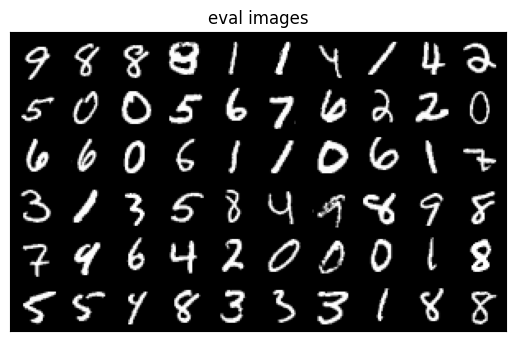

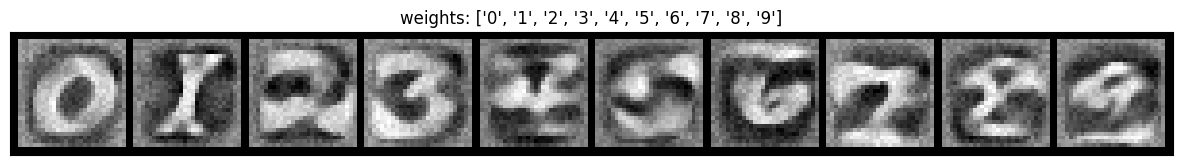

In [9]:
##### Set hyperparameters
batch_size = 600
epochs = 3
learning_rate = 1e-3
patience_limit = 2 # set to None if don't want it
save_model_file = f"model_{batch_size}.pth" # -||-
verbose = True
debug = False

##### Train
# Initialize dataset iterators
labels = [str(i) for i in range(10)]
train_dataloader = DataLoader(training_data_digits, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data_digits, batch_size=batch_size, shuffle=True)
# Calculate input size based on dataset shape
input_size = torch.tensor(next(iter(train_dataloader))[0].size()[1:]).prod()
print(f"INFO: Input size: {input_size}")
# Initialize model
model = NeuralNetwork(input_size=input_size).to(device)
print(model)
# Choose loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Train
model = training_loop(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                device=device,
                loss_fn=loss_fn,
                optimizer=optimizer,
                batch_size=batch_size,
                epochs=epochs,
                learning_rate=learning_rate,
                patience_limit=patience_limit,
                model_file=save_model_file,
                verbose=verbose,
                debug=debug)

##### Evaluate and visualize
evaluate(test_dataloader, model, device, labels)
visualize_weights(model, labels)


#### Fashion

INFO: Input size: 784
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)
TEST: Test evaluation: 
TEST: 	Accuracy: 10.8% 
TEST: 	Avg loss: 2.304236 



  0%|          | 0/3 [00:00<?, ?it/s]

TRAINING_LOOP: Epoch 1
-------------------------------
TRAIN: Batch 10, Loss: 1.820412  [ 6000/60000]
TRAIN: Batch 20, Loss: 1.748475  [12000/60000]
TRAIN: Batch 30, Loss: 1.716033  [18000/60000]
TRAIN: Batch 40, Loss: 1.731569  [24000/60000]
TRAIN: Batch 50, Loss: 1.679609  [30000/60000]
TRAIN: Batch 60, Loss: 1.713693  [36000/60000]
TRAIN: Batch 70, Loss: 1.690671  [42000/60000]
TRAIN: Batch 80, Loss: 1.703221  [48000/60000]
TRAIN: Batch 90, Loss: 1.689750  [54000/60000]
TRAIN: Batch 100, Loss: 1.701636  [60000/60000]


 33%|███▎      | 1/3 [00:07<00:15,  7.75s/it]

TEST: Test evaluation: 
TEST: 	Accuracy: 78.2% 
TEST: 	Avg loss: 1.692501 

TRAINING_LOOP: Loss improved. Saving model state to model_600.pth
TRAINING_LOOP: Epoch 2
-------------------------------
TRAIN: Batch 10, Loss: 1.684722  [ 6000/60000]
TRAIN: Batch 20, Loss: 1.701523  [12000/60000]
TRAIN: Batch 30, Loss: 1.668979  [18000/60000]
TRAIN: Batch 40, Loss: 1.685912  [24000/60000]
TRAIN: Batch 50, Loss: 1.685742  [30000/60000]
TRAIN: Batch 60, Loss: 1.685416  [36000/60000]
TRAIN: Batch 70, Loss: 1.669285  [42000/60000]
TRAIN: Batch 80, Loss: 1.659681  [48000/60000]
TRAIN: Batch 90, Loss: 1.663105  [54000/60000]
TRAIN: Batch 100, Loss: 1.666525  [60000/60000]


 67%|██████▋   | 2/3 [00:15<00:07,  7.79s/it]

TEST: Test evaluation: 
TEST: 	Accuracy: 79.8% 
TEST: 	Avg loss: 1.671998 

TRAINING_LOOP: Loss improved. Saving model state to model_600.pth
TRAINING_LOOP: Epoch 3
-------------------------------
TRAIN: Batch 10, Loss: 1.677471  [ 6000/60000]
TRAIN: Batch 20, Loss: 1.627257  [12000/60000]
TRAIN: Batch 30, Loss: 1.643943  [18000/60000]
TRAIN: Batch 40, Loss: 1.689308  [24000/60000]
TRAIN: Batch 50, Loss: 1.630403  [30000/60000]
TRAIN: Batch 60, Loss: 1.657140  [36000/60000]
TRAIN: Batch 70, Loss: 1.683522  [42000/60000]
TRAIN: Batch 80, Loss: 1.650706  [48000/60000]
TRAIN: Batch 90, Loss: 1.636693  [54000/60000]
TRAIN: Batch 100, Loss: 1.631152  [60000/60000]


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]

TEST: Test evaluation: 
TEST: 	Accuracy: 80.3% 
TEST: 	Avg loss: 1.664490 

TRAINING_LOOP: Loss improved. Saving model state to model_600.pth
Done! Best accuracy was 80.28%, test loss: 1.6644901738447302
tensor shape x: torch.Size([600, 1, 28, 28]), y: torch.Size([600]), y_pred: torch.Size([600, 10])
Incorrect pred - id: 2, pred: T-shirt/top, actual: Dress
Incorrect pred - id: 9, pred: Dress, actual: Shirt
Incorrect pred - id: 15, pred: T-shirt/top, actual: Shirt
Incorrect pred - id: 21, pred: Dress, actual: Shirt
Incorrect pred - id: 26, pred: Sandal, actual: Sneaker
Incorrect pred - id: 28, pred: Coat, actual: Pullover
Incorrect pred - id: 35, pred: T-shirt/top, actual: Shirt
Incorrect pred - id: 39, pred: Coat, actual: Dress
Incorrect pred - id: 40, pred: Coat, actual: T-shirt/top
Incorrect pred - id: 41, pred: Coat, actual: Shirt
Incorrect pred - id: 43, pred: Dress, actual: Trouser
Incorrect pred - id: 44, pred: Dress, actual: Shirt
Incorrect pred - id: 47, pred: Sneaker, actual: 

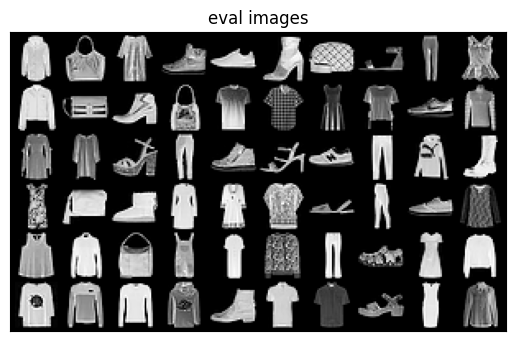

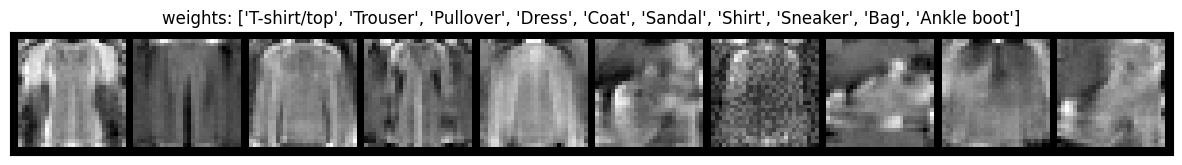

In [10]:
##### Set hyperparameters
batch_size = 600
epochs = 3
learning_rate = 1e-2
patience_limit = 2 # set to None if don't want it
save_model_file = f"model_{batch_size}.pth" # -||-
verbose = True
debug = False

##### Train
# Initialize dataset iterators
labels = ['T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
train_dataloader = DataLoader(training_data_fashion, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data_fashion, batch_size=batch_size, shuffle=True)

# Calculate input size based on dataset shape
input_size = torch.tensor(next(iter(train_dataloader))[0].size()[1:]).prod()
print(f"INFO: Input size: {input_size}")
# Initialize model
model = NeuralNetwork(input_size=input_size).to(device)
print(model)
# Choose loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Train
model = training_loop(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                device=device,
                loss_fn=loss_fn,
                optimizer=optimizer,
                batch_size=batch_size,
                epochs=epochs,
                learning_rate=learning_rate,
                patience_limit=patience_limit,
                model_file=save_model_file,
                verbose=verbose,
                debug=debug)

##### Evaluate and visualize
evaluate(test_dataloader, model, device, labels)
visualize_weights(model, labels)

### Last layer visual representation

At this point I expected to see visible representation of the numbers in weights, just like in https://ml4a.github.io/ml4a/looking_inside_neural_nets/
I think I'm doing something wrong. It seems to me that although the weights might represent the patterns of the images, the actual weights that do so, probably are randomized, so I would need to reorder the weights to see something meaningful, I would need to find which neuron is where.
Other option is that I am doing something wrong, haha.

**EDIT**: actually that was the case. I first attempted to visualize weights in 2nd layer. It was a noise, because indeed in single-layer network, the output weights are literally representation of what they are supposed to detect. If you want to see 0 -> the shape of zero must have highest coefficients. But below is still interesting idea. It would be interesting now to see how network represents shapes that have different sizes.

But if my intuition is correct I think there's an interesting experiment to be made:
1. Generate simple pattern - maybe circle - but of definite variety, for example one smaller, one bigger (o and O)
2. Train model to detect circle without distincting between the sizes of the circle
3. Save last layer of forward propagation for a circle from "small o" set and "big O" set to see which neurons get triggered
**EDIT**: it would be interesting to train model that detects number of circles and maybe 8's.

Or another experiment with squares. Detect squares and see the output layer for each of them -> then you can detect which neurons overlap. For example if you have 3x3 square, you can have 5 different squares (assuming pixel is not a square):  
□■■　■■□　□□□　□□□　■■■  
□■■　■■□　■■□　□■■　■■■  
□□□　□□□　■■□　□■■　■■■  
　0　 　　1　　　2　　 　3　　　4  



So Square 0 and square 2 share small part of NN:  
□□□  
□■□  
□□□  
Maybe I should read about set theory, because it seems like there's some interesting connection, perhaps it can give me insights about how to think about it, how to setup the experiment.


In [11]:
class SquareNeuralNetwork(nn.Module):
   def __init__(self, input_size=100, output_size=1):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(input_size, output_size),
        nn.Softmax(dim=1)
    )

   def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [12]:
from torch.utils.data import Dataset
class SquareCustomDataset(Dataset):
    def __init__(self, data_tuples, dtype=torch.float32):
        self.inputs = []
        self.labels = []
        for (inp, label) in data_tuples:
            self.inputs.append(inp.to(torch.float32))
            self.labels.append(label.to(torch.long))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        X = self.inputs[idx]
        Y = self.labels[idx]
        return X, Y

In [13]:
squares_ds = []
squares_ds.append((torch.tensor([[[0, 1, 1],
                             [0, 1, 1],
                             [0, 0, 0]]]), torch.tensor(0)))
squares_ds.append((torch.tensor([[[1, 1, 0],
                             [1, 1, 0],
                             [0, 0, 0]]]), torch.tensor(0)))
squares_ds.append((torch.tensor([[[0, 0, 0],
                             [1, 1, 0],
                             [1, 1, 0]]]), torch.tensor(0)))
squares_ds.append((torch.tensor([[[0, 0, 0],
                             [0, 1, 1],
                             [0, 1, 1]]]), torch.tensor(0)))
squares_ds.append((torch.tensor([[[1, 1, 1],
                             [1, 1, 1],
                             [1, 1, 1]]]), torch.tensor(0)))

squares_ds.append((torch.tensor([[[0, 1, 1],
                         [0, 0, 1],
                         [0, 0, 0]]]), torch.tensor(1)))
squares_ds.append((torch.tensor([[[1, 0, 0],
                         [1, 1, 0],
                         [0, 0, 1]]]), torch.tensor(1)))
squares_ds.append((torch.tensor([[[0, 1, 0],
                         [1, 1, 0],
                         [1, 0, 0]]]), torch.tensor(1)))
squares_ds.append((torch.tensor([[[1, 0, 0],
                         [0, 1, 1],
                         [0, 1, 1]]]), torch.tensor(1)))
squares_ds.append((torch.tensor([[[1, 1, 1],
                             [1, 0, 1],
                             [1, 1, 1]]]), torch.tensor(1)))

training_data_square = SquareCustomDataset(squares_ds)

INFO: Input size: 9
SquareNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=9, out_features=2, bias=True)
    (1): Softmax(dim=1)
  )
)
TEST: Test evaluation: 
TEST: 	Accuracy: 40.0% 
TEST: 	Avg loss: 0.695670 



  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_18/1217176014.py:18: RuntimeWarning: invalid value encountered in scalar remainder
  if verbose and ((batch+1) % verbose_period == 0.0):
100%|██████████| 20/20 [00:00<00:00, 423.08it/s]

TRAINING_LOOP: Epoch 1
-------------------------------
TEST: Test evaluation: 
TEST: 	Accuracy: 50.0% 
TEST: 	Avg loss: 0.684151 

TRAINING_LOOP: Loss improved. Saving model state to model_10.pth
TRAINING_LOOP: Epoch 2
-------------------------------
TEST: Test evaluation: 
TEST: 	Accuracy: 60.0% 
TEST: 	Avg loss: 0.652947 

TRAINING_LOOP: Loss improved. Saving model state to model_10.pth
TRAINING_LOOP: Epoch 3
-------------------------------
TEST: Test evaluation: 
TEST: 	Accuracy: 70.0% 
TEST: 	Avg loss: 0.634056 

TRAINING_LOOP: Loss improved. Saving model state to model_10.pth
TRAINING_LOOP: Epoch 4
-------------------------------
TEST: Test evaluation: 
TEST: 	Accuracy: 80.0% 
TEST: 	Avg loss: 0.591303 

TRAINING_LOOP: Loss improved. Saving model state to model_10.pth
TRAINING_LOOP: Epoch 5
-------------------------------
TEST: Test evaluation: 
TEST: 	Accuracy: 80.0% 
TEST: 	Avg loss: 0.582205 

TRAINING_LOOP: Loss improved. Saving model state to model_10.pth
TRAINING_LOOP: Epoch

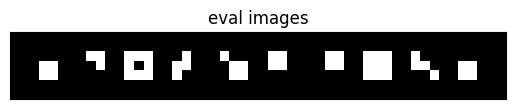

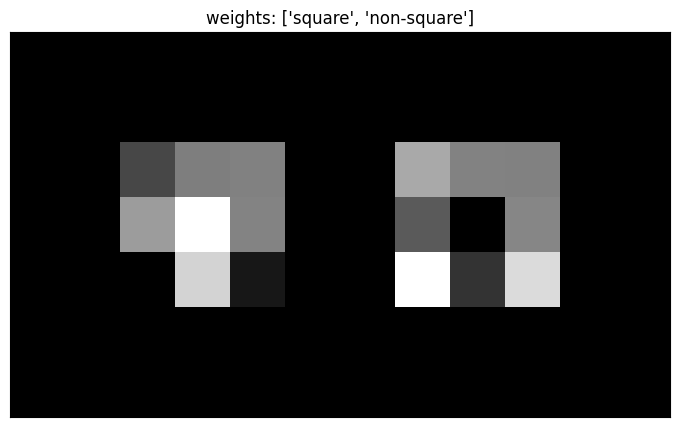

In [14]:
##### Set hyperparameters
batch_size = len(squares_ds)
epochs = 20
learning_rate = 4e-1
patience_limit = 2 # set to None if don't want it
save_model_file = f"model_{batch_size}.pth" # -||-
verbose = True
debug = False

##### Train
# Initialize dataset iterators
labels = ['square', "non-square"]
train_dataloader = DataLoader(training_data_square, batch_size=batch_size, shuffle=True)

# Calculate input size based on dataset shape
input_size = torch.tensor(next(iter(train_dataloader))[0].size()[1:]).prod()
print(f"INFO: Input size: {input_size}")
# Initialize model
model = SquareNeuralNetwork(input_size=input_size, output_size=len(labels)).to(device)
print(model)
# Choose loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Train
model = training_loop(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=train_dataloader,
                device=device,
                loss_fn=loss_fn,
                optimizer=optimizer,
                batch_size=batch_size,
                epochs=epochs,
                learning_rate=learning_rate,
                patience_limit=patience_limit,
                model_file=save_model_file,
                verbose=verbose,
                debug=debug)

##### Evaluate and visualize
evaluate(train_dataloader, model, device, labels, max_numbers=10)
visualize_weights(model, labels)